In [1]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from fittingtask import FittingTask
import os
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
homedir = os.path.expanduser('~')
def normalized_cmap(val, low, high, cmap):
    cmap = plt.get_cmap(cmap)
    rang=high-low
    return cmap(int((val-low)*255/rang))
c = 2.99792e5 # km/s

### Default (ownwcoef)

In [155]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_2M0036/SDCK*.spec_a0v.fits'))

fluxes = []
wls = []
for filename in filelist:
    hdu = fits.open(filename)
    flux = hdu[0].data
    wl = hdu[1].data

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    fluxes.append(flux)
    wls.append(wl)

dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)
obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
eobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
wfobs0 = 1./eobs0**2   # make noise spectrum
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

nobs = dims[0]
norders = 20
npix = dims[2]

In [156]:
resultdir = f"{homedir}/uoedrive/result/CIFIST"
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
wcoef = {}
ccoef = {}
modellist = []
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_chipmods_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_chiplams_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_fitting*-5.*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
    wcoef[modelname] = np.array([[float(i) for i in wc.split(',')] for wc in results['wcoef']])
    ccoef[modelname] = np.array([[float(i) for i in wc.split(',')] for wc in results['ccoef']])
chisq.keys()

dict_keys(['lte012.0-5.0', 'lte012.0-5.5', 'lte013.0-5.0', 'lte013.0-5.5', 'lte014.0-5.0', 'lte014.0-5.5', 'lte015.0-5.0', 'lte015.0-5.5', 'lte015.5-5.0', 'lte015.5-5.5', 'lte016.0-5.0', 'lte016.0-5.5', 'lte016.5-5.5', 'lte017.0-5.0', 'lte017.0-5.5', 'lte017.5-5.0', 'lte017.5-5.5', 'lte018.0-5.0', 'lte018.0-5.5', 'lte018.5-5.5', 'lte019.0-5.0', 'lte019.0-5.5'])

#### Plot $\chi^2$ vs orders and observations

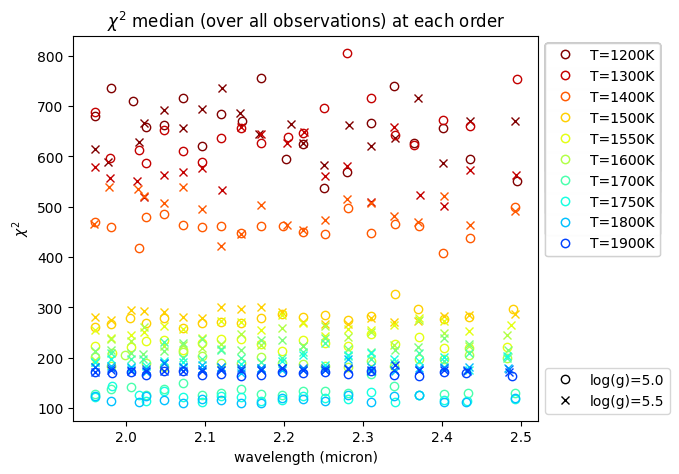

In [15]:
# chisq vs. order(wavelength), median over observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("$\chi^2$ median (over all observations) at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

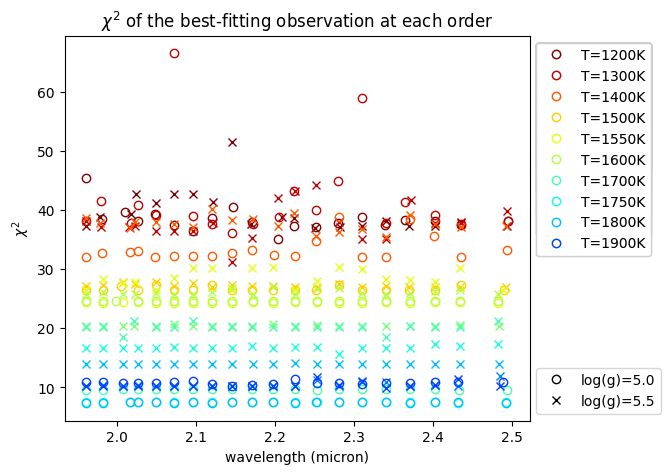

In [16]:
# chisq vs. order(wavelength), min of all observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.min(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.min(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("$\chi^2$ of the best-fitting observation at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

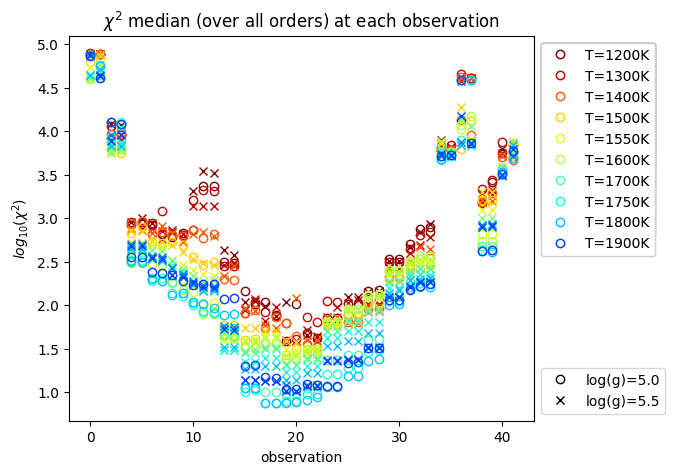

In [18]:
# chisq vs. observations, median over orders
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=1) # plot one point per obs
        obs_points = np.arange(nobs) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=1) # plot one point per obs
        obs_points = np.arange(nobs) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("observation")
    plt.ylabel("$log_{10}(\chi^2)$")
    plt.title("$\chi^2$ median (over all orders) at each observation")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

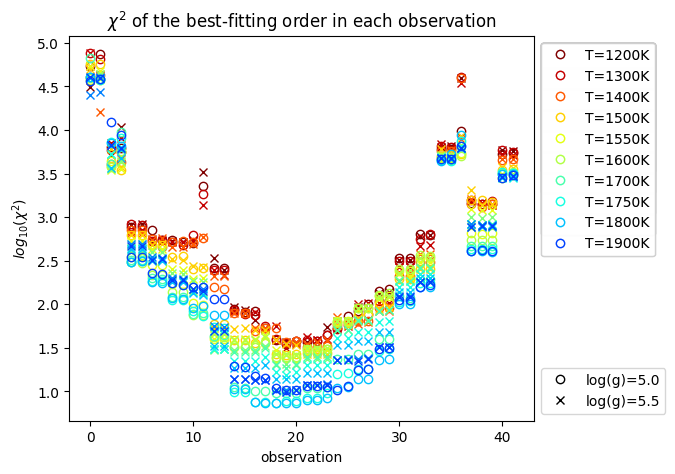

In [20]:
# chisq vs. observations, min of all orders
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.min(chisq[model].reshape((nobs,norders)), axis=1) # plot one point per obs
        obs_points = np.arange(nobs) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.min(chisq[model].reshape((nobs,norders)), axis=1) # plot one point per obs
        obs_points = np.arange(nobs) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("observation")
    plt.ylabel("$log_{10}(\chi^2)$")
    plt.title("$\chi^2$ of the best-fitting order in each observation")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

#### Find best-fits

In [21]:
# find the best-fitting obs at each order
best_ind = {}
for model in modellist:
    chisq_this = np.array(chisq[model].reshape((nobs, norders)))
    min_chisqs = np.min(chisq_this, axis=0)
    best_ind[model] = (chisq_this==min_chisqs)

In [158]:
# find best-fit model
df = pd.DataFrame({
    'model name':[model for model in modellist], 
    'median':[np.median(chisq[model]) for model in modellist], 
    'mean':[np.mean(chisq[model]) for model in modellist], 
    'min':[np.min(chisq[model]) for model in modellist]
})
df = df.sort_values(by=['mean'])
df.style.hide(axis="index")

model name,median,mean,min
lte015.5-5.0,241.894465,3644.723498,24.307760
lte017.0-5.5,201.065347,3847.245813,18.472689
lte017.5-5.5,193.460392,3862.521712,15.583062
lte016.0-5.0,205.501115,3884.132508,24.577891
lte018.0-5.5,180.518094,3995.574111,13.874668
lte016.0-5.5,245.878732,4037.563392,25.798412
lte016.5-5.5,222.749830,4320.122880,20.377481
lte018.5-5.5,179.436285,4326.171502,10.256431
lte019.0-5.5,178.253645,4445.955159,9.953478
lte015.5-5.5,257.563576,4668.615691,26.482382


#### Plot best-fit parameters in each order and observation

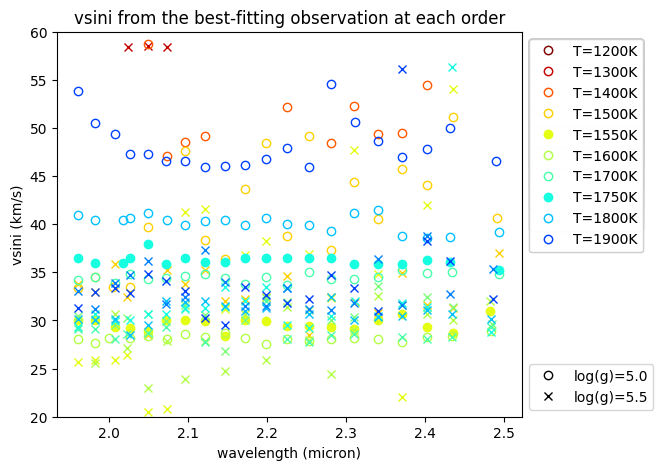

In [42]:
# fitted vsini vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        if "17.5" in model or "15.5" in model:
            mfc=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r')
        else:
            mfc='none'
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        vsini_points = vsini[model].reshape((nobs,norders))[best_ind[model]]
        plt.plot(lam_points, vsini_points, "o", mfc=mfc, color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        vsini_points = vsini[model].reshape((nobs,norders))[best_ind[model]]
        plt.plot(lam_points, vsini_points, "x", mfc="none", color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("vsini (km/s)")
    plt.ylim((20,60))
    plt.title("vsini from the best-fitting observation at each order")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

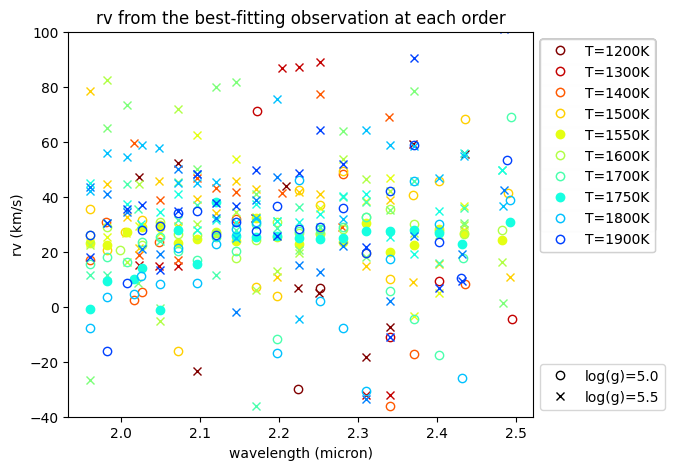

In [46]:
# fitted rv vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
    rv_points = rv[model].reshape((nobs, norders))[best_ind[model]] * c
    if "-5.0" in model:
        if "17.5" in model or "15.5" in model:
            mfc=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r')
        else:
            mfc='none'
        plt.plot(lam_points, rv_points, "o", mfc=mfc, color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        plt.plot(lam_points, rv_points, "x", mfc="none", color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("rv (km/s)")
    plt.ylim((-40,100))
    plt.title("rv from the best-fitting observation at each order")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

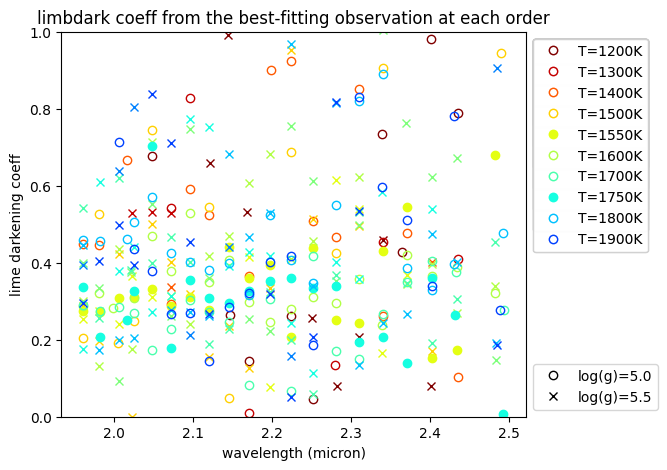

In [47]:
# fitted lld vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
    lld_points = lld[model].reshape((nobs, norders))[best_ind[model]]
    if "-5.0" in model:
        if "17.5" in model or "15.5" in model:
            mfc=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r')
        else:
            mfc='none'
        plt.plot(lam_points, lld_points, "o", mfc=mfc, color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        plt.plot(lam_points, lld_points, "x", mfc="none", color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("lime darkening coeff")
    plt.ylim((0,1))
    plt.title("limbdark coeff from the best-fitting observation at each order")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

#### Plot best-fit spectrum

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte017.5-5.0')

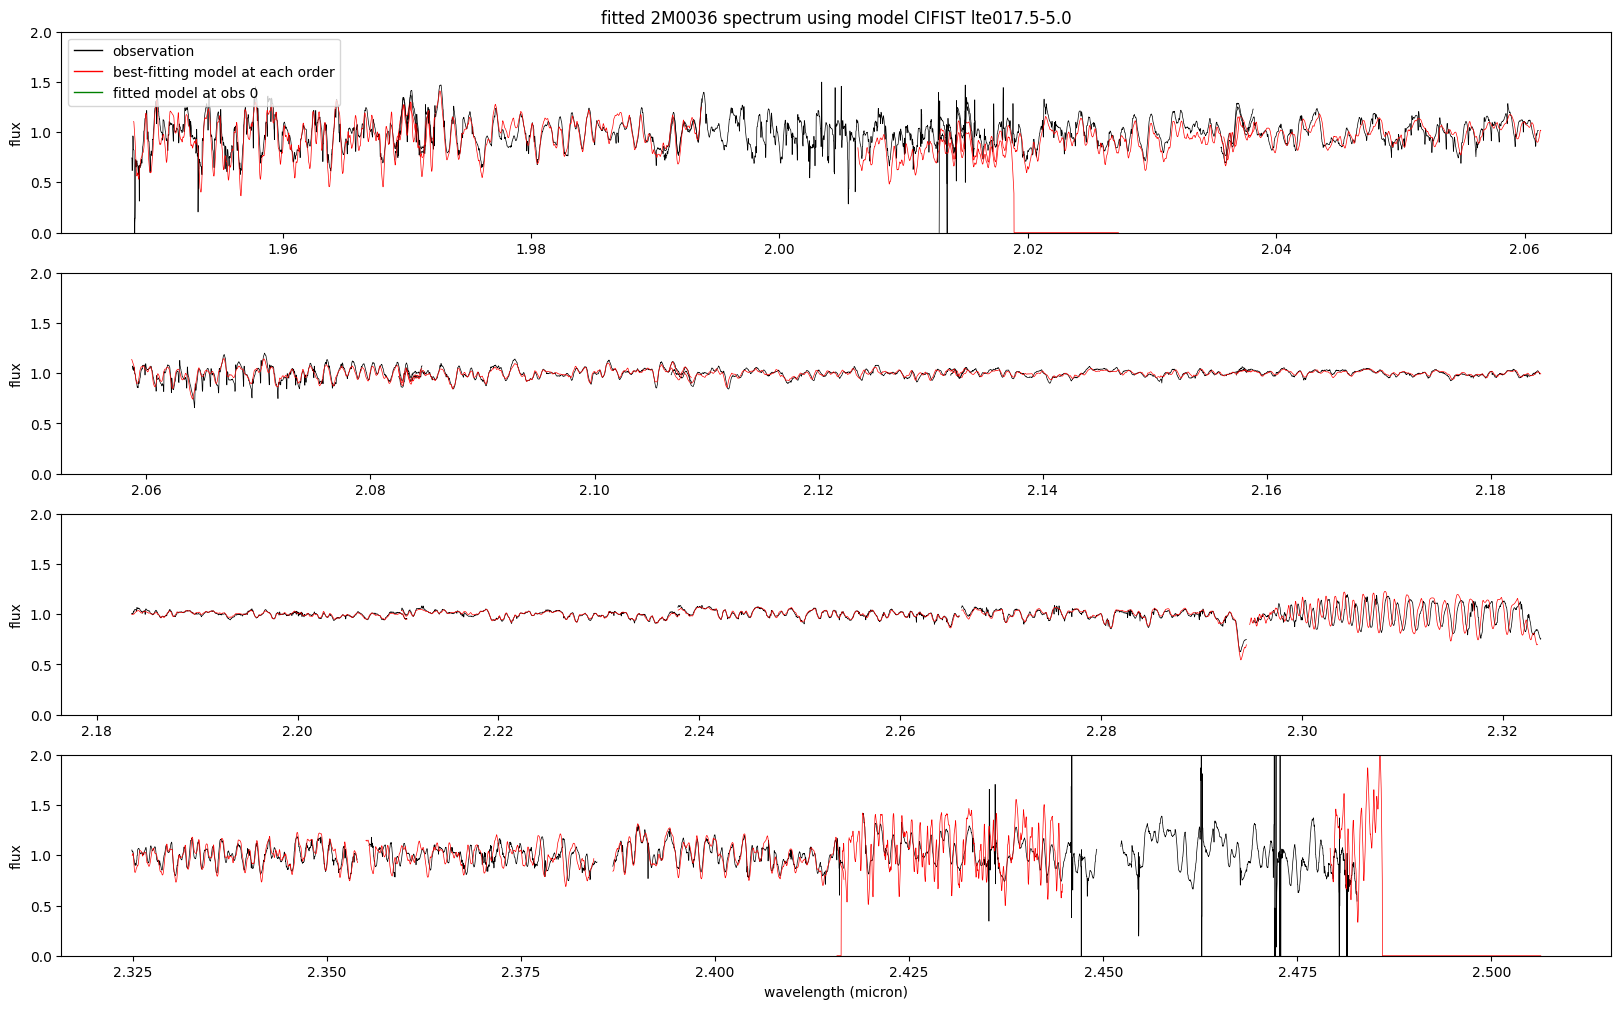

In [90]:
model = 'lte017.5-5.0'
obs = best_ind[model]
obsn = 0
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,12))
wcoef_this = wcoef[model].reshape((nobs, norders,4))[21]
pix = np.arange(npix, dtype=float)/npix

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        # plot best fitting obs of each order
        plt.plot(chiplams[model][obs[:,jj], jj,:].flatten(), chipmods[model][obs[:,jj], jj,:].flatten(), linewidth=0.5, color="r", label="fitted")
        # plot obs 21 of each order
        #plt.plot(chiplams[model][obsn,jj], chipmods[model][obsn, jj], linewidth=0.5, color="g", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),
                        Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting model at each order", f"fitted model at obs {obsn}"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte015.5-5.0')

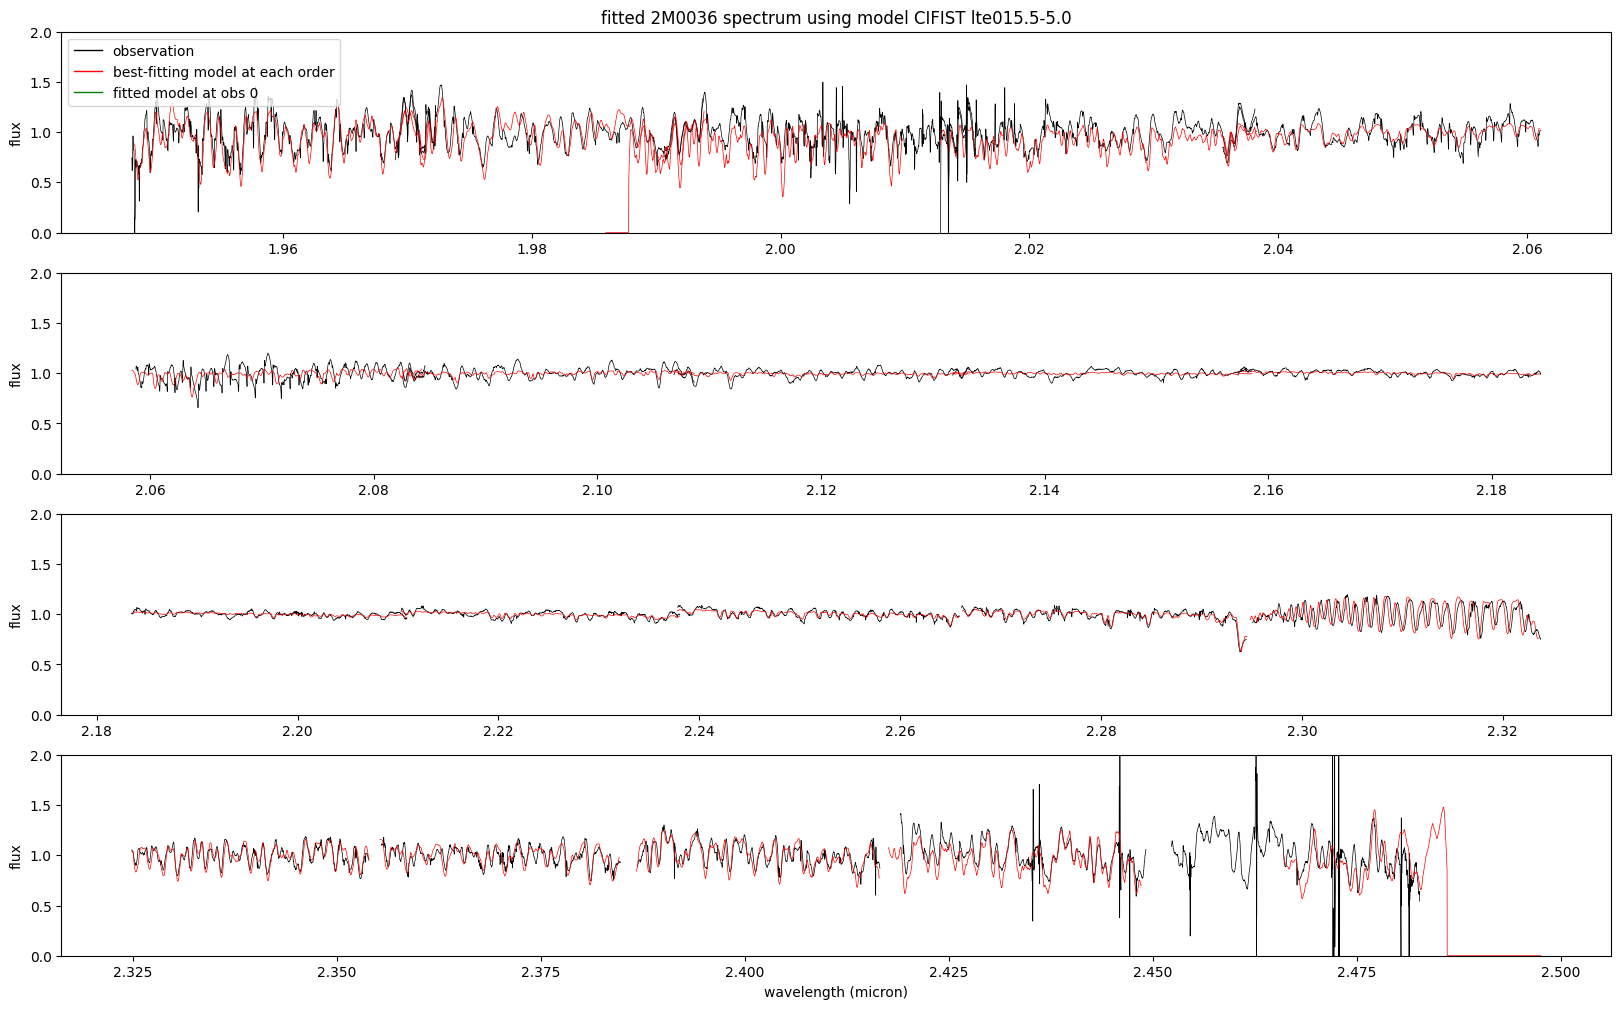

In [91]:
model = 'lte015.5-5.0'
obs = best_ind[model]
obsn = 0
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,12))
wcoef_this = wcoef[model].reshape((nobs, norders,4))[21]
pix = np.arange(npix, dtype=float)/npix

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        # plot best fitting obs of each order
        plt.plot(chiplams[model][obs[:,jj], jj,:].flatten(), chipmods[model][obs[:,jj], jj,:].flatten(), linewidth=0.5, color="r", label="fitted")
        # plot obs 21 of each order
        #plt.plot(chiplams[model][obsn,jj], chipmods[model][obsn, jj], linewidth=0.5, color="g", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),
                        Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting model at each order", f"fitted model at obs {obsn}"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")

Use a single vsini for all orders.

In [113]:
obsn=22
model='lte017.5-5.0'
vsini_mean = vsini[model].reshape(nobs,norders).mean()
rv_this = rv[model].reshape(nobs,norders)[obsn]
lld_this = lld[model].reshape(nobs,norders)[obsn]
wcoef_this = wcoef[model].reshape(nobs,norders, 4)[obsn]
ccoef_this = ccoef[model].reshape(nobs,norders, 2)[obsn]

In [130]:
[vsini_mean, lld_this[jj], rv_this[jj]] + list(wcoef_this[jj]) + list(ccoef_this[jj])

[36.22165224084088,
 0.6067068010573264,
 -3.877285682244575e-05,
 9.265333899744776e-05,
 -0.003434487682186415,
 0.03046121691627564,
 2.157253677455534,
 -0.024243495282557384,
 1.0198482307941739]

In [136]:
results['wcoef'].reshape(42,20)[22]

array(['0.00013162748645013212, -0.0033750715132653403, 0.030366828699964044, 2.1572685374062908',
       '5.1123766687599466e-05, -0.0033469990917180574, 0.03041020420168476, 2.1572044063177884',
       '0.00016297612482906522, -0.0034850577396977975, 0.030446870502317952, 2.1572572490452995',
       '0.00012169087912380127, -0.0034615057972689394, 0.030460041079034963, 2.157247659976484',
       '0.0001297200555469492, -0.0034112073433438753, 0.030404503824377198, 2.1572653085895',
       '0.00014847026671403963, -0.00352689718885983, 0.030506654338430556, 2.1571980576650756',
       '8.884331511889654e-05, -0.0034003139093025316, 0.030428325165388632, 2.157266676695306',
       '0.00014040977319465755, -0.0035219147577627997, 0.03050723998543306, 2.157204012749263',
       '0.0001279347154141848, -0.0034825802556931592, 0.030476113346147634, 2.1572193763233023',
       '0.00013948159475946076, -0.0035052791000162262, 0.03048888452613291, 2.1571942020589345',
       '0.00014804748450

In [129]:
wcoef_this = [[float(j) for j in results['wcoef'].reshape(42,20)[22][jj].split(",")] for jj in range(20)]

In [137]:
import modelfitting as mf
chiplams_vsini = []
chipmods_vsini = []
for jj in range(norders):
    modelpath = f"{homedir}/uoedrive/data/BTSettlg5/lte017.5-5.0-0.0a+0.0.BT-Settl.spec.fits"
    model = Table.read(modelpath, format='fits')
    modelname = modelpath.split("/")[-1]
    model['wl'] = model['Wavelength']
    model['flux'] = model['Flux']
    lolim = wls[:, jj, :].min() - 0.003
    hilim = wls[:, jj, :].max() + 0.003
    tind = (model['wl']>lolim) * (model['wl'] < hilim)
    lam_template = model['wl'][tind]
    template = model['flux'][tind]
    template /= np.median(template)
    NPC=2
    NPW=4
    
    mymod, myw = mf.modelspec_template(
        [vsini_mean, lld_this[jj], rv_this[jj]] + list(wcoef_this[jj]) + list(ccoef_this[jj]),
        lam_template,
        template,
        NPW,
        NPC,
        npix,
        retlam=True)
    chiplams_vsini.append(myw)
    chipmods_vsini.append(mymod)

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte017.5-5.0')

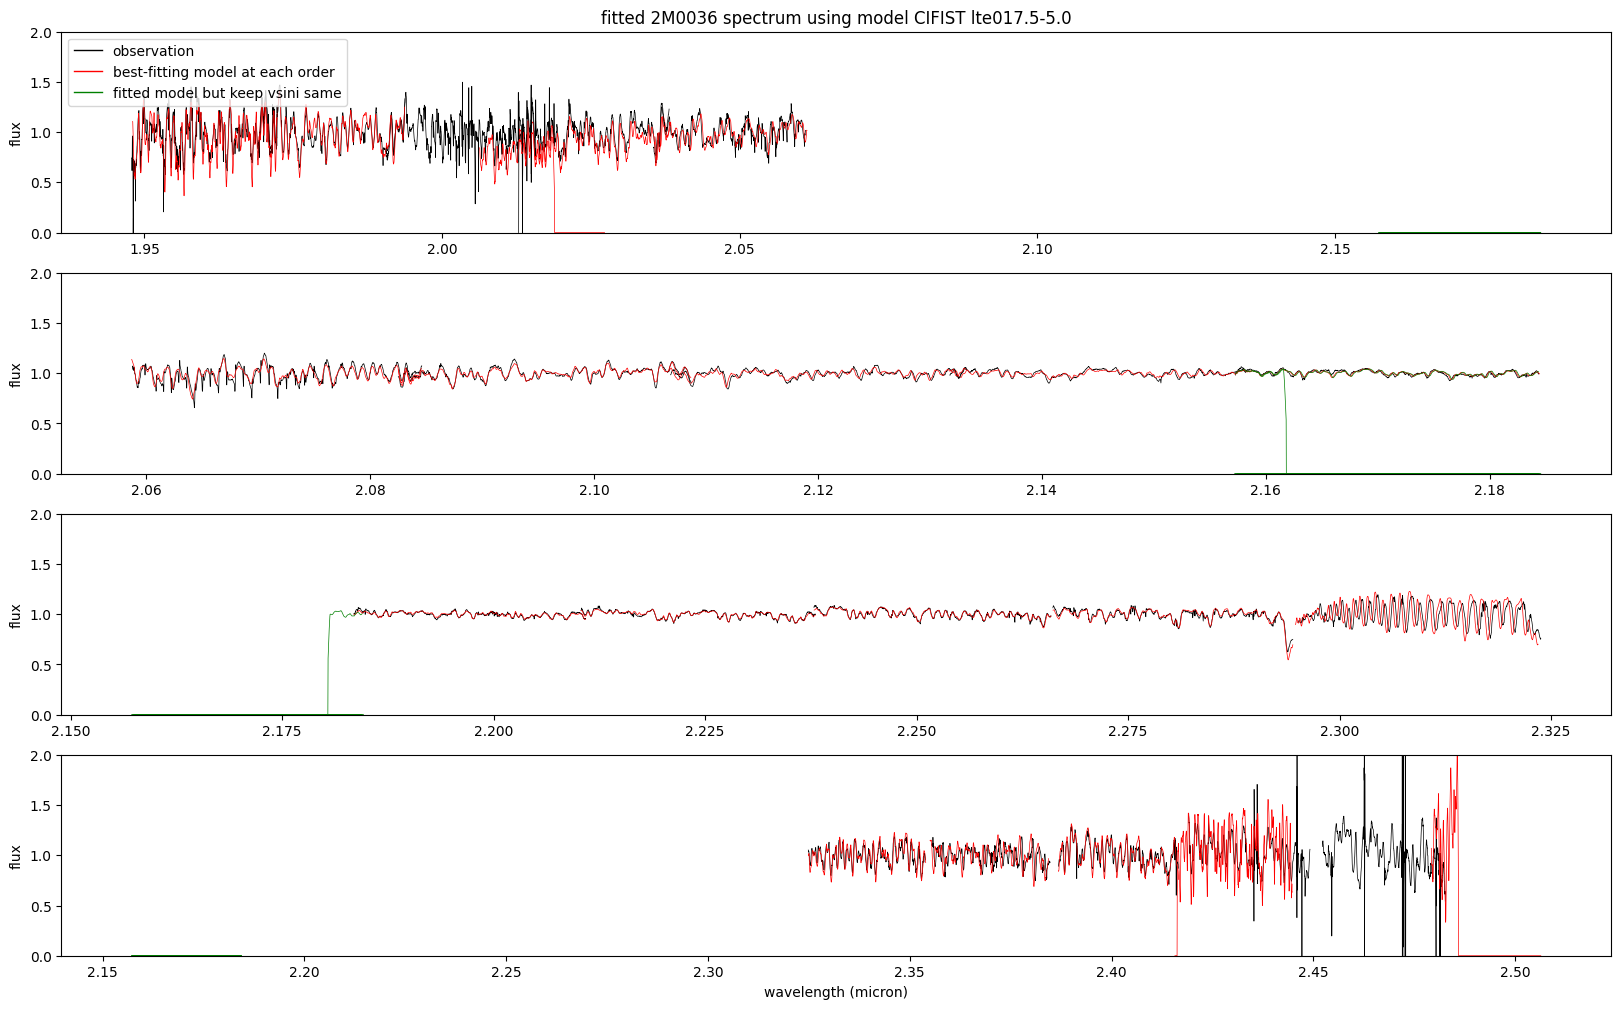

In [138]:
model = 'lte017.5-5.0'
obs = best_ind[model]
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,12))
wcoef_this = wcoef[model].reshape((nobs, norders,4))[21]
pix = np.arange(npix, dtype=float)/npix

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        # plot best fitting obs of each order
        plt.plot(chiplams[model][obs[:,jj], jj,:].flatten(), chipmods[model][obs[:,jj], jj,:].flatten(), linewidth=0.5, color="r", label="fitted")
        # plot chimods if vsini keep same
        plt.plot(chiplams_vsini[jj], chipmods_vsini[jj], linewidth=0.5, color="g", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),
                        Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting model at each order", f"fitted model but keep vsini same"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")

### Non-stack

#### Load observed data for comparison

In [25]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_2M0036/SDCK*.spec_a0v.fits'))

fluxes = []
wls = []
for filename in filelist:
    hdu = fits.open(filename)
    flux = hdu[0].data
    wl = hdu[1].data

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    fluxes.append(flux)
    wls.append(wl)

dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

# remove first order with all NaNs when making various arrays
obs0 = fluxes[:, 1:, :]*dims[0]
eobs0 = fluxes[:, 1:, :]*np.sqrt(dims[0])  # make noise spectrum (assuming just photon noise)
fobs0 = np.array([[signal.medfilt(obs0[obs,jj], 3) for jj in range(dims[1]-1)] for obs in range(dims[0])])
fobs0 /= np.array([np.nanmedian(fobs0[obs], axis=1) for obs in range(dims[0])]).reshape(dims[0], dims[1]-1, 1)
eobs0 /= np.array([np.nanmedian(fobs0[obs], axis=1) for obs in range(dims[0])]).reshape(dims[0], dims[1]-1, 1)
wfobs0 = 1./eobs0**2   # make noise spectrum
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :]

#### Load K band results

In [7]:
resultdir = f"{homedir}/uoedrive/result/CIFIST"
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_nonstack_chipmods_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_nonstack_chiplams_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_nonstack_*-5.*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['lte015.0-5.0'])

In [26]:
norders = 20
nobs = 42
obs = 0

In [45]:
# chisq vs. order(wavelength), median over observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    #plt.ylim(10, 1e5)
    #plt.yscale("log")
    plt.title("$\chi^2$ median (over all observations) at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

<Figure size 600x500 with 0 Axes>

#### Plot $\chi^2$ vs orders and observations

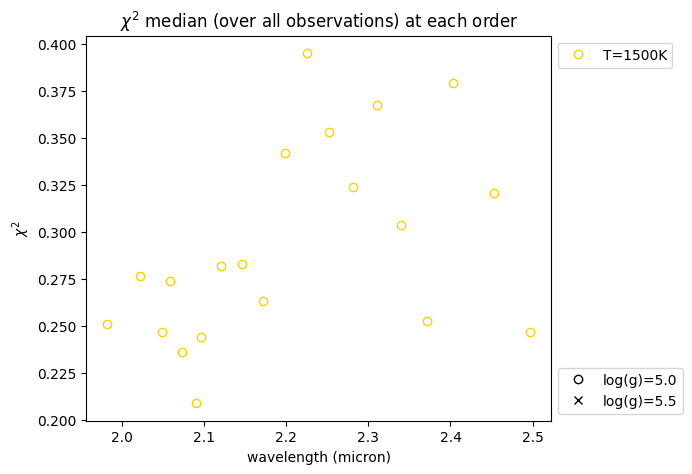

In [23]:
# chisq vs. order(wavelength), median over observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    #plt.ylim(10, 1e5)
    #plt.yscale("log")
    plt.title("$\chi^2$ median (over all observations) at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

In [27]:
fobs0.shape

(42, 25, 1848)

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte015.0-5.0,   obs=22')

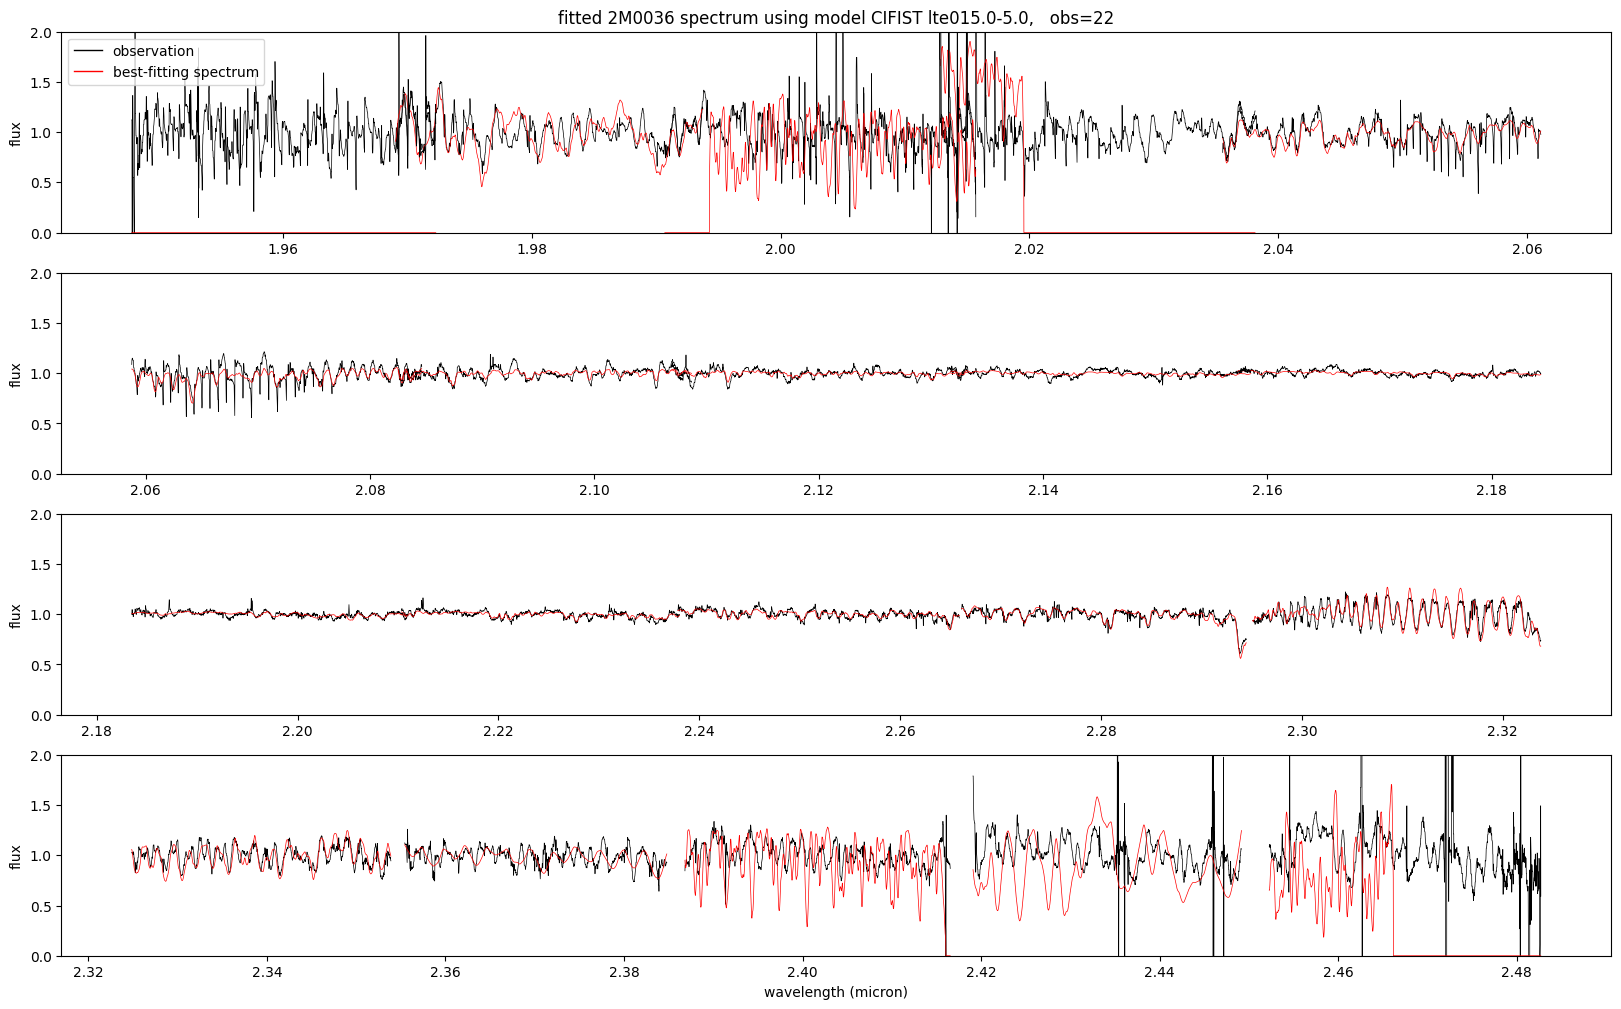

In [41]:
model = 'lte015.0-5.0'
obs = 22
fobs = fobs0[obs, :20, :]
wobs = wls[obs, :20, :]
plt.figure(figsize=(20,12))

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        plt.plot(wobs[jj,:], chipmods[model][obs, jj,:].flatten(), linewidth=0.5, color="r", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),]
                        #Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting spectrum"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model},   obs={obs}")

In [97]:
lams_avg = chiplams[model][obs, :,:]

array([[2.47344192, 2.47346112, 2.47348031, ..., 2.50562189, 2.50563773,
        2.50565358],
       [2.41507373, 2.41509646, 2.41511918, ..., 2.44874984, 2.44876427,
        2.4487787 ],
       [2.38705359, 2.38707194, 2.38709028, ..., 2.41670583, 2.41671967,
        2.41673351],
       ...,
       [1.98781693, 1.98782984, 1.98784275, ..., 2.00846768, 2.00847722,
        2.00848675],
       [1.9687505 , 1.96876546, 1.96878042, ..., 1.99344671, 1.99345866,
        1.99347061],
       [1.9481356 , 1.94814992, 1.94816423, ..., 1.97233898, 1.97235085,
        1.97236272]])

In [102]:
lams_first = chiplams[model][obs, :,:]

In [108]:
lams_last = chiplams[model][obs, :,:]

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte015.0-5.0')

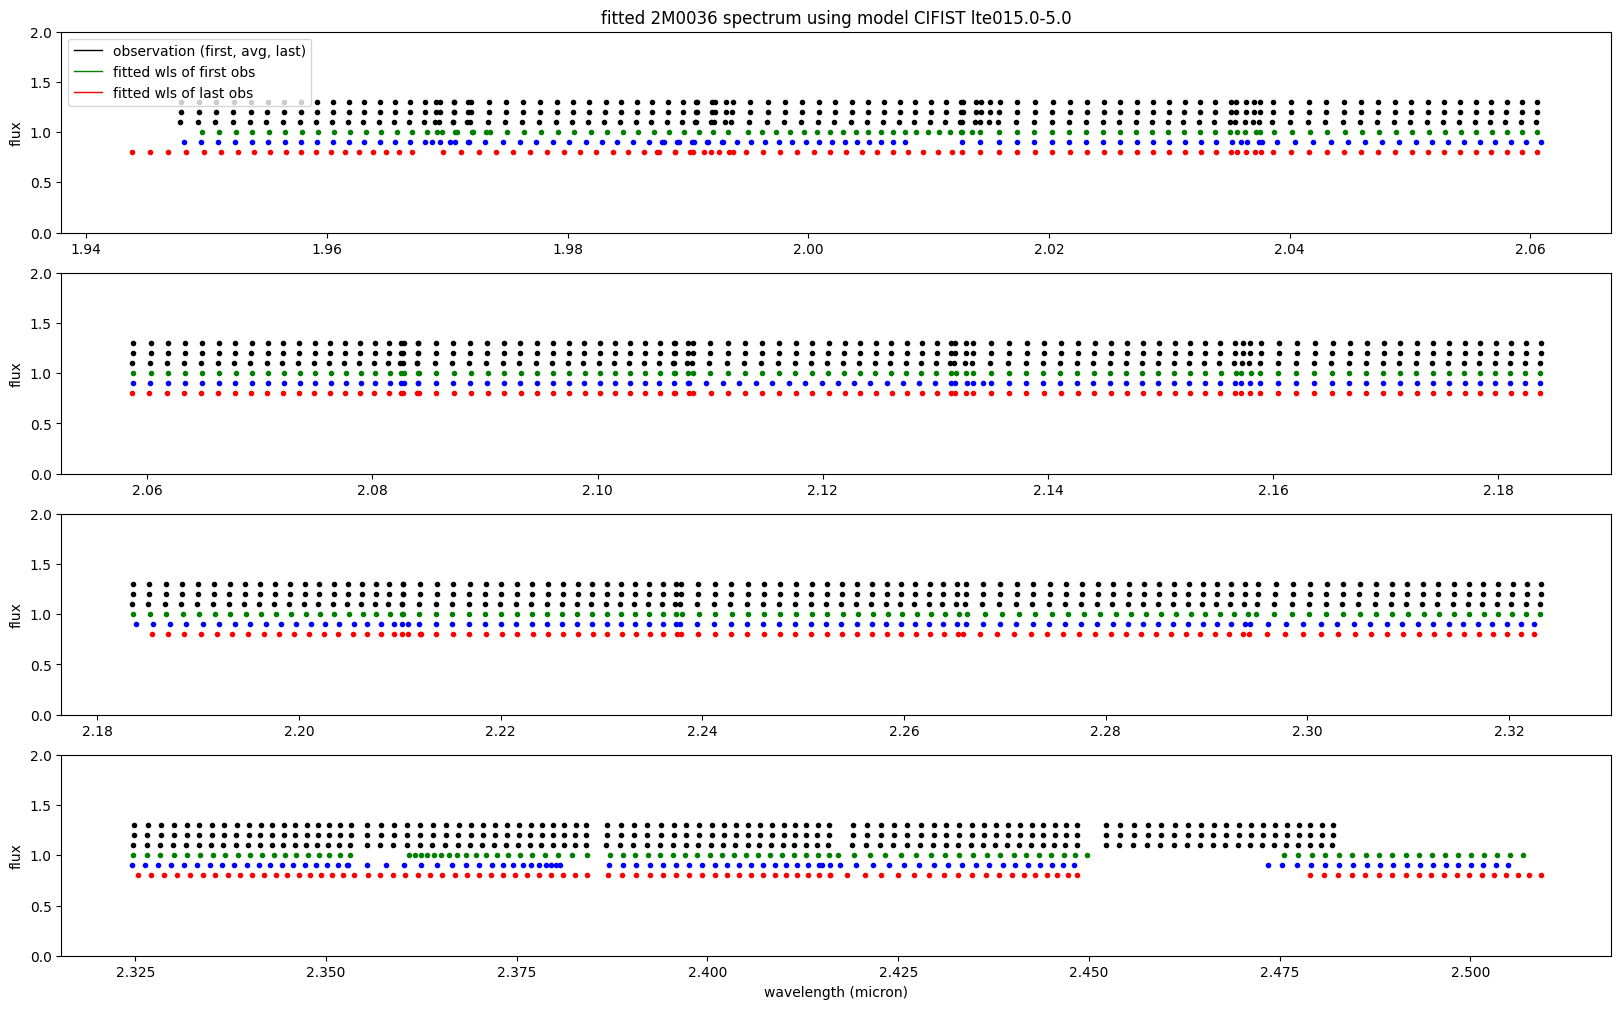

In [116]:
# plot the lambda points
model = 'lte015.0-5.0'
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
wobs_first = wls[0][:20]
wobs_last = wls[-1][:20]
plt.figure(figsize=(20,12))

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs_first[jj,::100], 1.3*np.ones(len(wobs_first[jj,::100])), ".", color="black", label="observation")
        plt.plot(wobs[jj,::100], 1.2*np.ones(len(wobs[jj,::100])), ".", color="black", label="observation")
        plt.plot(wobs_last[jj,::100], 1.1*np.ones(len(wobs_last[jj,::100])), ".", color="black", label="observation")
        plt.plot(lams_first[jj, ::100], 1*np.ones(len(lams_first[jj, ::100])), ".", color="green", label="wls of first obs")
        plt.plot(lams_avg[jj,::100], 0.9*np.ones(len(lams_avg[jj, ::100])), ".", color="blue", label="wls of avg obs")
        plt.plot(lams_last[jj, ::100], 0.8*np.ones(len(lams_last[jj,::100])), ".", color="r", label="wls of last obs")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="k", lw=1),
                        Line2D([0], [0], color="green", lw=1),
                        Line2D([0], [0], color="r", lw=1),]
        plt.legend(custom_lines, ["observation (first, avg, last)","fitted wls of first obs", "fitted wls of last obs"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")

### Callie's models

In [159]:
resultdir = f"{homedir}/uoedrive/result/Callie"
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_chipmods_*g1000*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_chiplams_*g1000*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_fitting_*g1000*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['t1400g1000f1', 't1400g1000f2', 't1400g1000f3', 't1400g1000f4', 't1400g1000f8', 't1400g1000nc', 't1500g1000f1', 't1500g1000f2', 't1500g1000f3', 't1500g1000f4', 't1500g1000f8'])

In [160]:
# find the best-fitting obs at each order
best_ind = {}
for model in modellist:
    chisq_this = np.array(chisq[model].reshape((42, 20)))
    min_chisqs = np.min(chisq_this, axis=0)
    best_ind[model] = (chisq_this==min_chisqs)

Text(0.5, 1.0, 'fitted spectrum using model Callie t1500g1000f8')

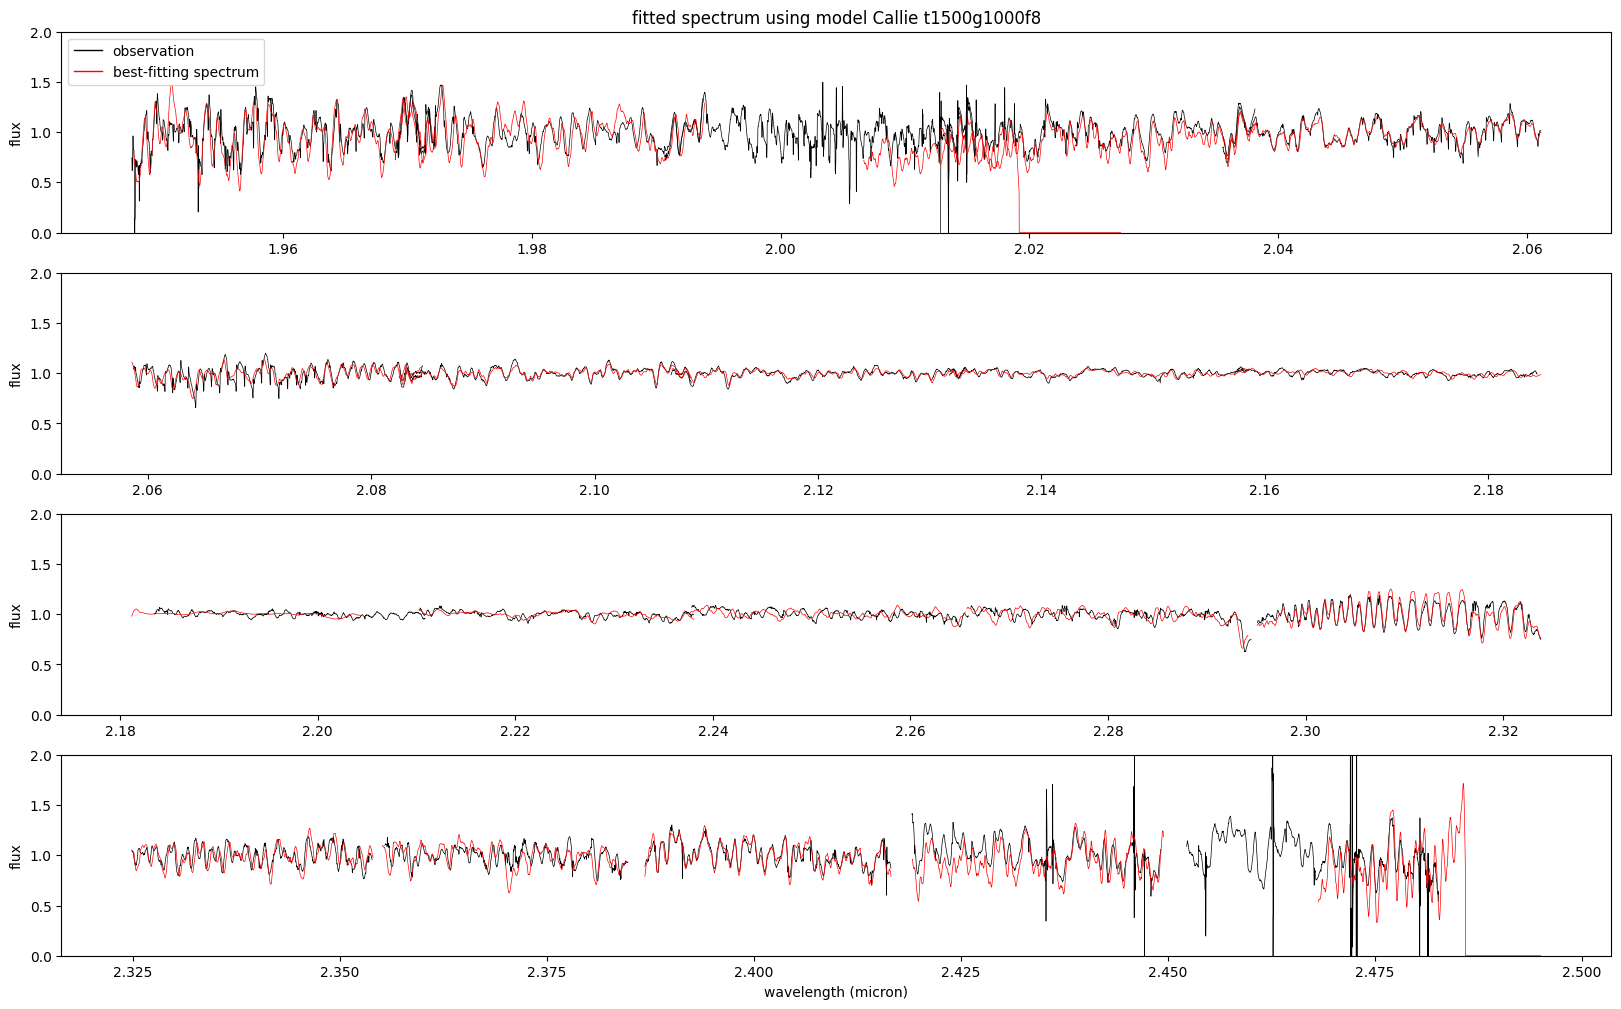

In [162]:
model = 't1500g1000f8'
obs = best_ind[model]
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,12))

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        plt.plot(chiplams[model][obs[:,jj], jj,:].flatten(), chipmods[model][obs[:,jj], jj,:].flatten(), linewidth=0.5, color="r", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),]
                        #Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting spectrum"], loc=2)
plt.title(f"fitted spectrum using model Callie {model}")

In [145]:
# matplotlib default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


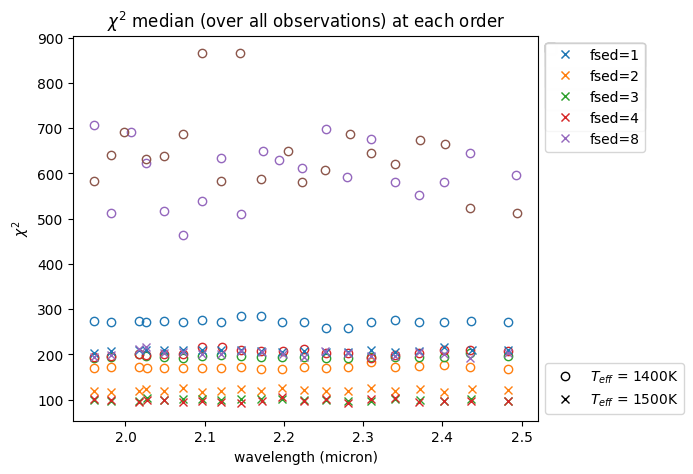

In [147]:
# chisq vs. order(wavelength), median over observations
plt.figure(figsize=(6,5))
i=0
for model in modellist:
    fsed = model[-2:]
    if "f" in fsed:
        label = f'fsed={fsed[1]}'
    else:
        label = 'no cloud'
    if "t1500" in model:
        chisq_points = np.median(chisq[model].reshape((42, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc='none', label=label)
    if "t1400" in model:
        chisq_points = np.median(chisq[model].reshape((42, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc="none", color=colors[i])
        i+=1
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("$\chi^2$ median (over all observations) at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["$T_{eff}$ = 1400K", "$T_{eff}$ = 1500K"],loc=3, bbox_to_anchor=(1,0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


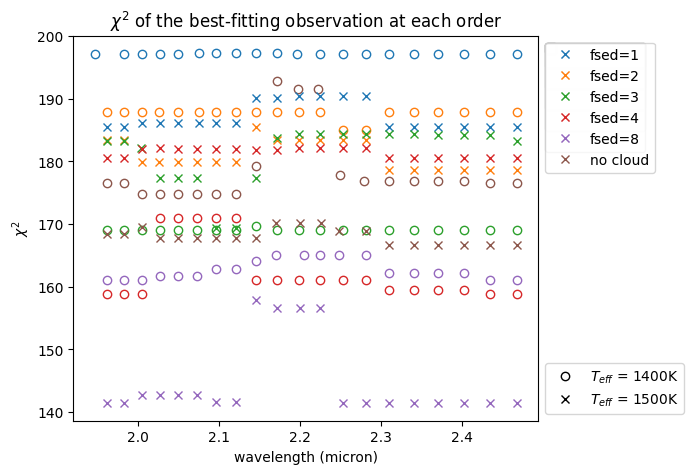

In [39]:
# chisq vs. order(wavelength), min of all observations
plt.figure(figsize=(6,5))
i=0
for model in modellist:
    fsed = model[-2:]
    if "f" in fsed:
        label = f'fsed={fsed[1]}'
    else:
        label = 'no cloud'
    if "t1500" in model:
        chisq_points = np.min(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc='none', label=label)
    if "t1400" in model:
        chisq_points = np.min(chisq[model].reshape((56, 20)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc="none", color=colors[i])
        i+=1
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("$\chi^2$ of the best-fitting observation at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["$T_{eff}$ = 1400K", "$T_{eff}$ = 1500K"],loc=3, bbox_to_anchor=(1,0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


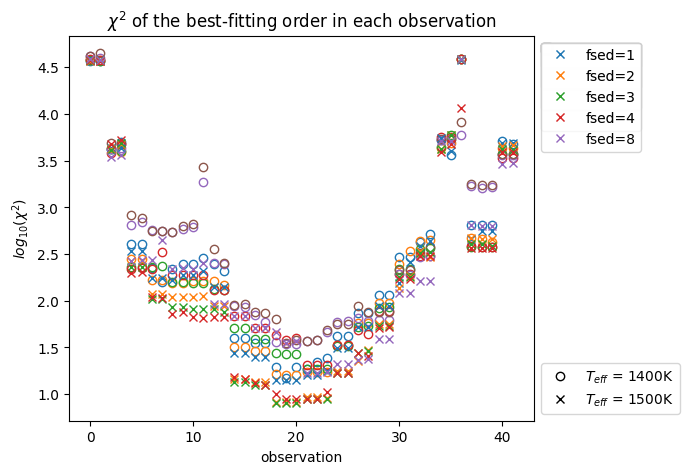

In [149]:
# chisq vs. observations, min of all orders
plt.figure(figsize=(6,5))
i=0
for model in modellist:
    fsed = model[-2:]
    if "f" in fsed:
        label = f'fsed={fsed[1]}'
    else:
        label = 'no cloud'
    if "t1400" in model:
        chisq_points = np.min(chisq[model].reshape((42, 20)), axis=1) # plot one point per obs
        obs_points = np.arange(42) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "o", mfc='none')
    if "t1500" in model:
        chisq_points = np.min(chisq[model].reshape((42, 20)), axis=1) # plot one point per obs
        obs_points = np.arange(42) # plot one point per obs
        plt.plot(obs_points, np.log10(chisq_points), "x", mfc="none", color=colors[i], label=label)
        i+=1
    plt.xlabel("observation")
    plt.ylabel("$log_{10}(\chi^2)$")
    plt.title("$\chi^2$ of the best-fitting order in each observation")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["$T_{eff}$ = 1400K", "$T_{eff}$ = 1500K"],loc=3, bbox_to_anchor=(1,0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


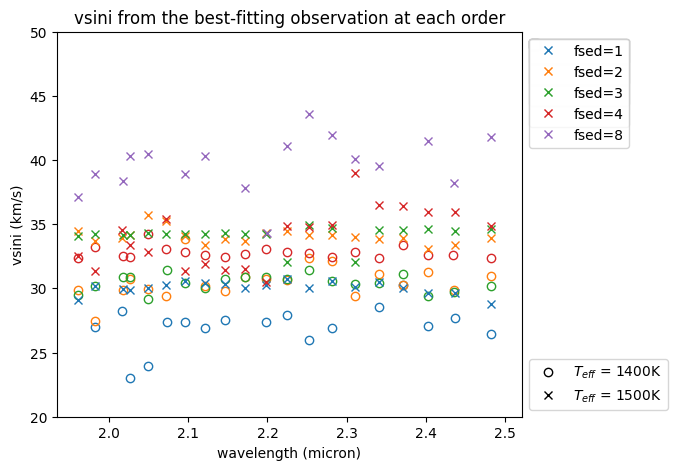

In [151]:
# fitted vsini vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
i=0
for model in modellist:
    fsed = model[-2:]
    if "f" in fsed:
        label = f'fsed={fsed[1]}'
    else:
        label = 'no cloud'
    if "t1400" in model:
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        vsini_points = vsini[model].reshape((42, 20))[best_ind[model]]
        plt.plot(lam_points, vsini_points, "o", mfc="none")
    if "t1500" in model:
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        vsini_points = vsini[model].reshape((42, 20))[best_ind[model]]
        plt.plot(lam_points, vsini_points, "x", mfc="none", color=colors[i], label=label)
        i+=1
    plt.xlabel("wavelength (micron)")
    plt.ylabel("vsini (km/s)")
    plt.ylim((20,50))
    plt.title("vsini from the best-fitting observation at each order")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["$T_{eff}$ = 1400K", "$T_{eff}$ = 1500K"],loc=3, bbox_to_anchor=(1,0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


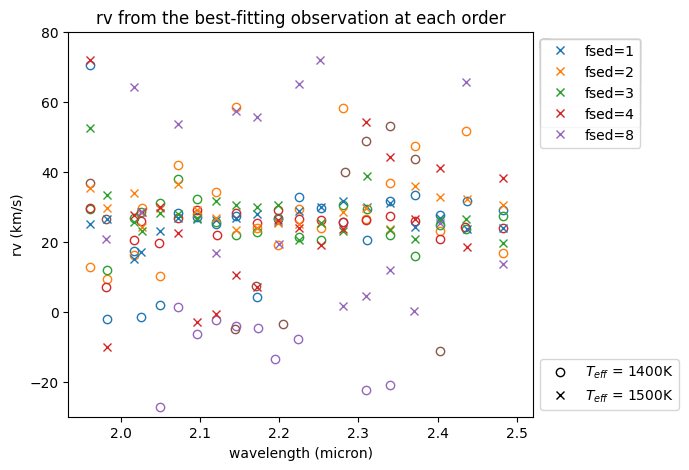

In [154]:
# fitted rv vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
i=0
for model in modellist:
    fsed = model[-2:]
    if "f" in fsed:
        label = f'fsed={fsed[1]}'
    else:
        label = 'no cloud'
    lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
    rv_points = rv[model].reshape((42, 20))[best_ind[model]] * c
    if "t1400" in model:
        plt.plot(lam_points, rv_points, "o", mfc="none")
    if "t1500" in model:
        plt.plot(lam_points, rv_points, "x", mfc="none", color=colors[i], label=label)
        i+=1
    plt.xlabel("wavelength (micron)")
    plt.ylabel("rv (km/s)")
    plt.ylim((-30,80))
    plt.title("rv from the best-fitting observation at each order")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["$T_{eff}$ = 1400K", "$T_{eff}$ = 1500K"],loc=3, bbox_to_anchor=(1,0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


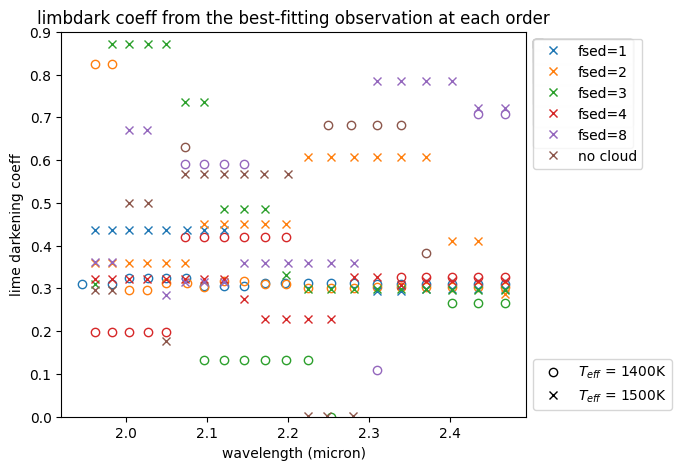

In [57]:
# fitted lld vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
i=0
for model in modellist:
    fsed = model[-2:]
    if "f" in fsed:
        label = f'fsed={fsed[1]}'
    else:
        label = 'no cloud'
    lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
    lld_points = lld[model].reshape((56, 20))[best_ind[model]]
    if "t1400" in model:
        plt.plot(lam_points, lld_points, "o", mfc="none")
    if "t1500" in model:
        plt.plot(lam_points, lld_points, "x", mfc="none", color=colors[i], label=label)
        i+=1
    plt.xlabel("wavelength (micron)")
    plt.ylabel("lime darkening coeff")
    plt.ylim((0,0.9))
    plt.title("limbdark coeff from the best-fitting observation at each order")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["$T_{eff}$ = 1400K", "$T_{eff}$ = 1500K"],loc=3, bbox_to_anchor=(1,0))